In [116]:
import itertools
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample, find_peaks, savgol_filter
from tqdm import tqdm
import uuid

In [3]:
dataset_df = pd.read_feather('data/dataset.feather')

In [117]:
sample_df = pd.read_excel('data/EURUSD_WEEKLY.xlsx', engine='openpyxl')
sample_data = sample_df.values.tolist()
origin_signal = [item[1] for item in sample_data]

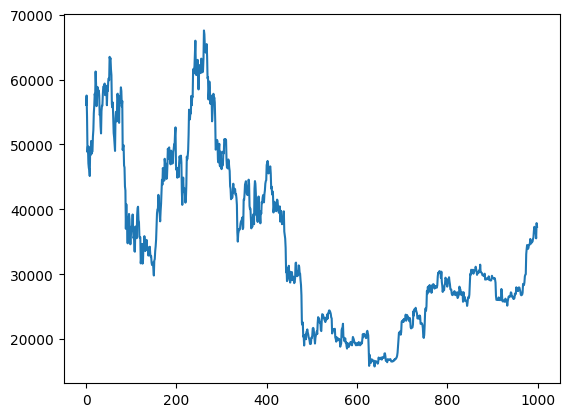

In [78]:
plt.plot(origin_signal)

In [118]:
if origin_signal[0] == None:
    origin_signal[0] = 0

for i in range(1, len(origin_signal)):
    if np.isnan(origin_signal[i]):
        origin_signal[i] = origin_signal[i-1]

reflected_signal = np.concatenate((origin_signal[::-1], origin_signal, origin_signal[::-1]))
resampled_reflected_signal = resample(reflected_signal, 3 * 1000)
origin_signal = list(resampled_reflected_signal[1000:2000])
origin_signal = origin_signal - np.mean(origin_signal)
origin_signal = origin_signal / np.linalg.norm(origin_signal)

In [80]:
origin_signal = np.array(origin_signal)
# Find indices of peaks in the filtered data
peaks, _ = find_peaks(origin_signal)

# Find indices of troughs in the filtered data by inverting the data
troughs, _ = find_peaks(-origin_signal)

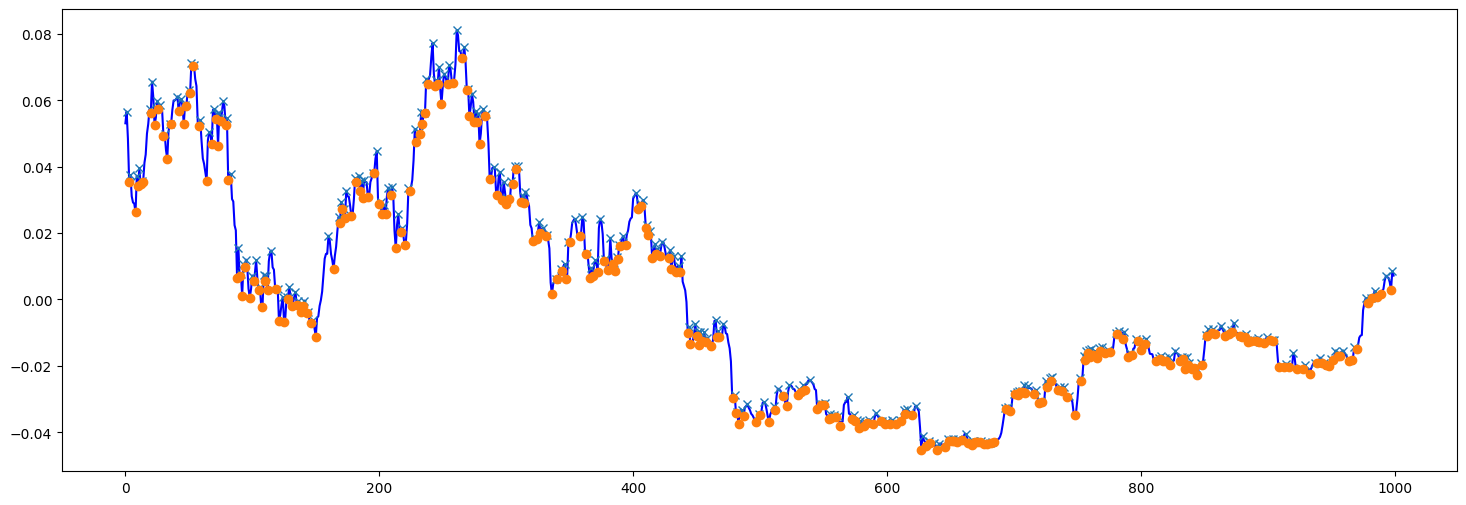

In [81]:
plt.figure(figsize=(18, 6))
plt.plot(origin_signal, label='Original', color='blue')
# Highlight peaks on the filtered data
plt.plot(peaks, origin_signal[peaks], "x", label='Peaks')

# Highlight troughs on the filtered data
plt.plot(troughs, origin_signal[troughs], "o", label='Troughs')

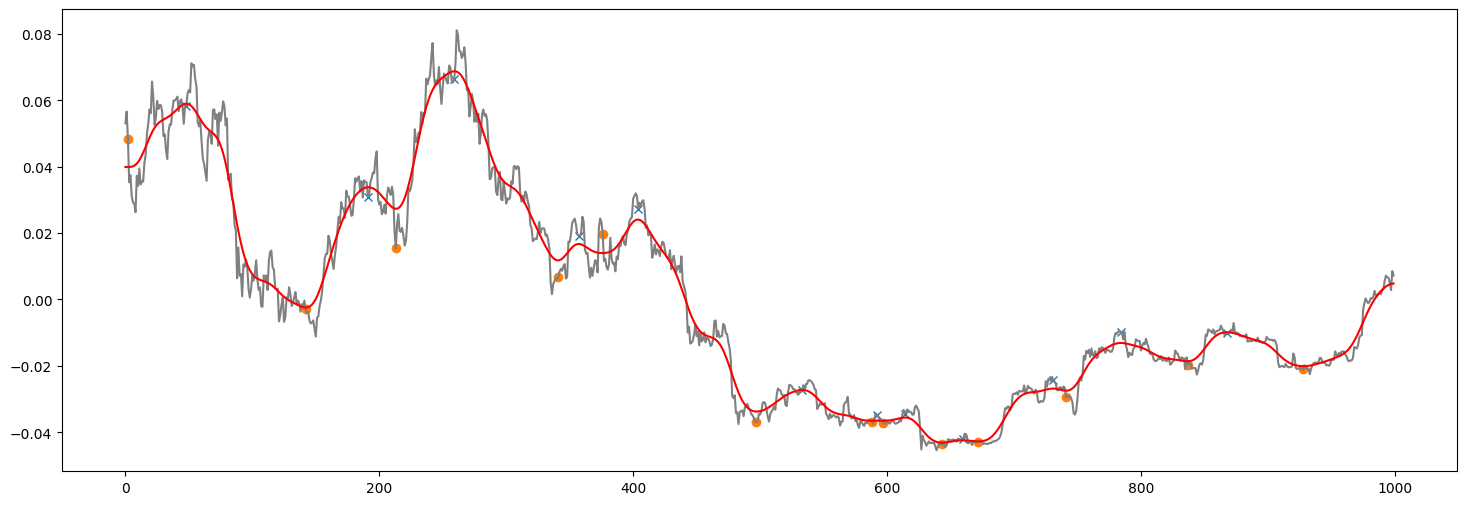

In [82]:
# Apply a Gaussian filter with a sigma of 1
sigma = 8
smooth_signal = gaussian_filter1d(origin_signal, sigma)

# Find indices of peaks in the filtered data
peaks, peak_prop = find_peaks(smooth_signal)
# Find indices of troughs in the filtered data by inverting the data
troughs, _ = find_peaks(-smooth_signal)

plt.figure(figsize=(18, 6))
# Highlight peaks on the filtered data
plt.plot(peaks, origin_signal[peaks], "x", label='Peaks')
# Highlight troughs on the filtered data
plt.plot(troughs, origin_signal[troughs], "o", label='Troughs')

plt.plot(origin_signal, label='Original', color='gray')
plt.plot(smooth_signal, label='Smoothed', color='red')

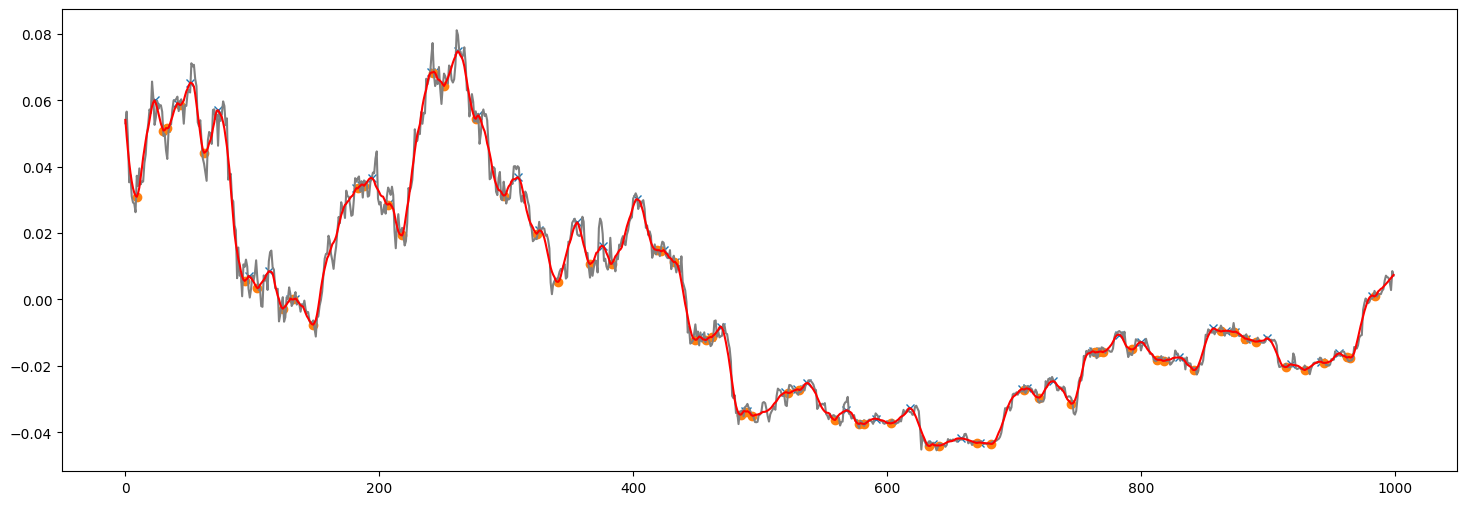

In [83]:
sg_signal = savgol_filter(origin_signal, window_length=20, polyorder=2)

# Find indices of peaks in the filtered data
peaks, peak_prop = find_peaks(sg_signal)
# Find indices of troughs in the filtered data by inverting the data
troughs, _ = find_peaks(-sg_signal)

plt.figure(figsize=(18, 6))
# Highlight peaks on the filtered data
plt.plot(peaks, sg_signal[peaks], "x", label='Peaks')
# Highlight troughs on the filtered data
plt.plot(troughs, sg_signal[troughs], "o", label='Troughs')

plt.plot(origin_signal, label='Original', color='gray')
plt.plot(sg_signal, label='Smoothed', color='red')

In [35]:
import numpy as np
from scipy.signal import butter, filtfilt

def normalize(x):
    return (x - np.mean(x)) / np.std(x)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


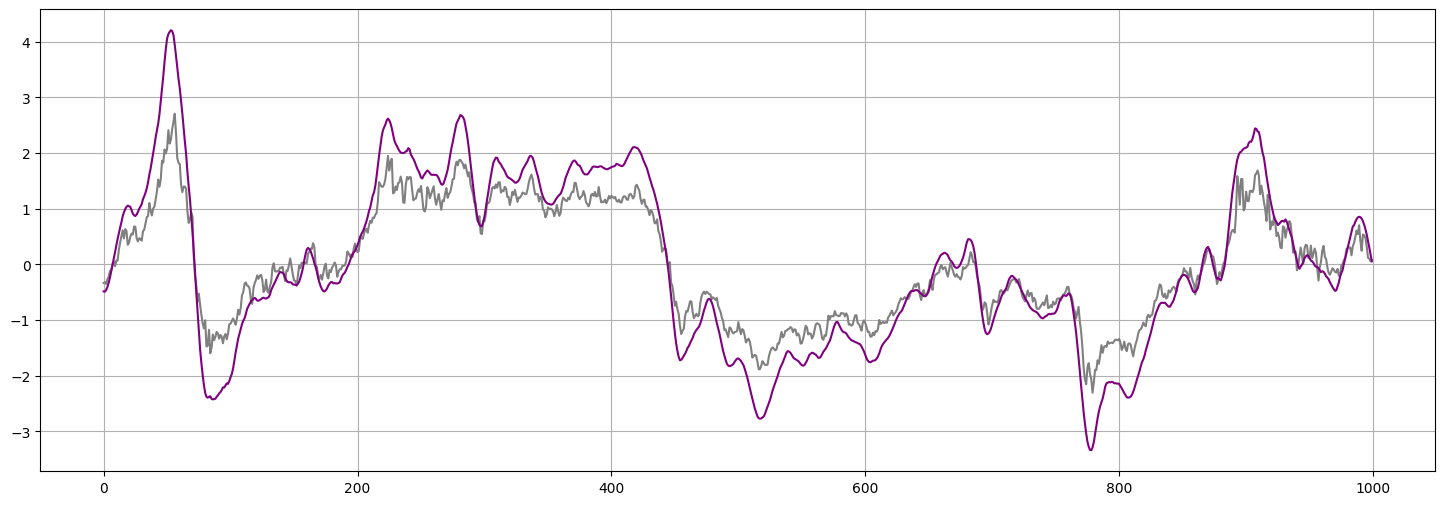

In [112]:
cutoff = 1/300
order = 3
hp_origin_signal = highpass_filter(origin_signal, cutoff=cutoff, fs=1, order=order)
# hp_origin_signal_2 = highpass_filter(origin_signal, cutoff=1/200, fs=1, order=order)
# hp_smooth_signal = highpass_filter(smooth_signal, cutoff=cutoff, fs=1, order=order)
# hp_sg_signal = highpass_filter(sg_signal, cutoff=cutoff, fs=1, order=order)
sg_hp_signal = savgol_filter(hp_origin_signal, window_length=30, polyorder=5)
lp_signal = origin_signal - hp_origin_signal

origin_signal = normalize(origin_signal)
lp_signal = normalize(lp_signal)
sg_hp_signal = normalize(sg_hp_signal)  
hp_origin_signal = normalize(hp_origin_signal)

plt.figure(figsize=(18, 6))
plt.plot(origin_signal, label='Original', color='gray')
# plt.plot(hp_origin_signal, label='Highpass', color='blue')
# plt.plot(sg_hp_signal, label='Smoothed', color='red')
# plt.plot(lp_signal, label='Lowpass', color='orange')
plt.plot(sg_hp_signal + lp_signal, label='Lowpass-squared', color='purple')
# plt.plot(sg_hp_signal*np.abs(sg_hp_signal)*200, label='Highpass-squared', color='purple')
# plt.plot(sg_hp_signal*np.abs(sg_hp_signal)*200 + lp_signal, label='Highpass-savgol', color='green')
# plt.plot(hp_origin_signal_2, label='Highpass-1', color='red')
# plt.plot(hp_origin_signal, label='Highpass-original', color='blue')
# plt.plot(hp_origin_signal*np.abs(hp_origin_signal)*100, label='Highpass-squared', color='red')
# plt.plot(hp_smooth_signal, label='Highpass-smoothed', color='red')
# plt.plot(hp_sg_signal, label='Highpass-savgol', color='green')
plt.grid(True)

In [106]:
from src.utils import resample_normalize

def normalize(x):
    return (x - np.mean(x)) / np.std(x)

def rhyme_func(origin_signal, window=1000):
    origin_signal = resample_normalize(origin_signal, window)
    cutoff = 1/300
    order = 3
    hp_signal = highpass_filter(origin_signal, cutoff=cutoff, fs=1, order=order)
    lp_signal = origin_signal - hp_signal
    sg_hp_signal = savgol_filter(hp_signal, window_length=60, polyorder=5)
    # rhyme_signal = sg_hp_signal*np.abs(sg_hp_signal)*200 + lp_signal
    rhyme_signal = normalize(sg_hp_signal * np.abs(sg_hp_signal)) + normalize(lp_signal) * 0.5
    # rhyme_signal = normalize(sg_hp_signal) + normalize(lp_signal) * 0.5
    
    return rhyme_signal.tolist()

36.16211759005944
36.329035223318634


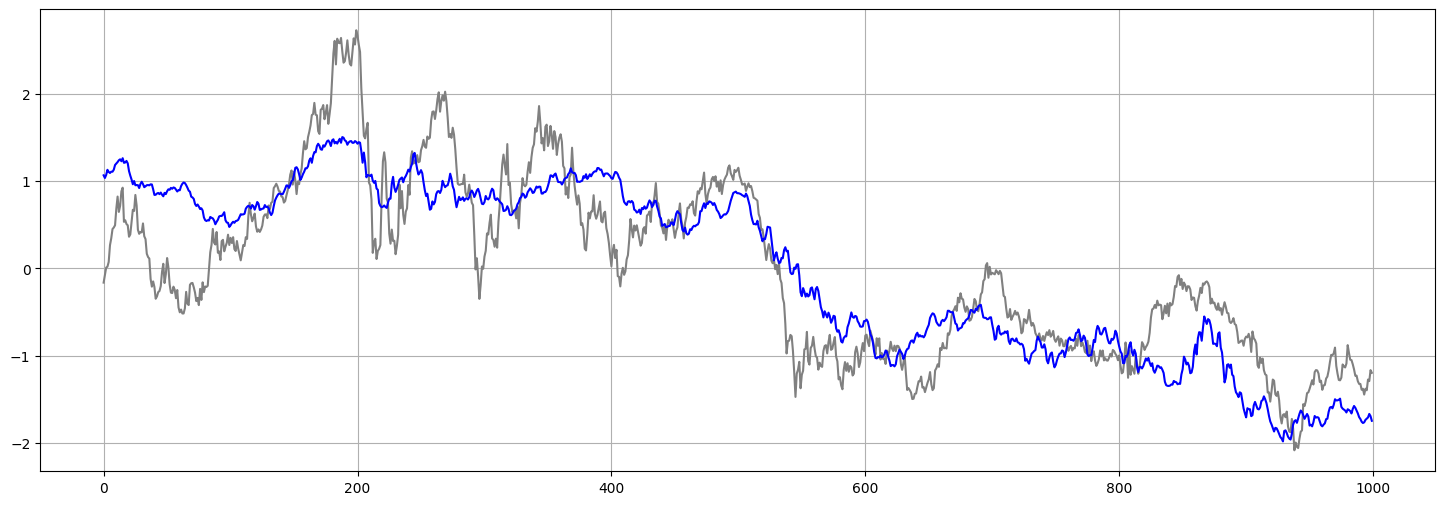

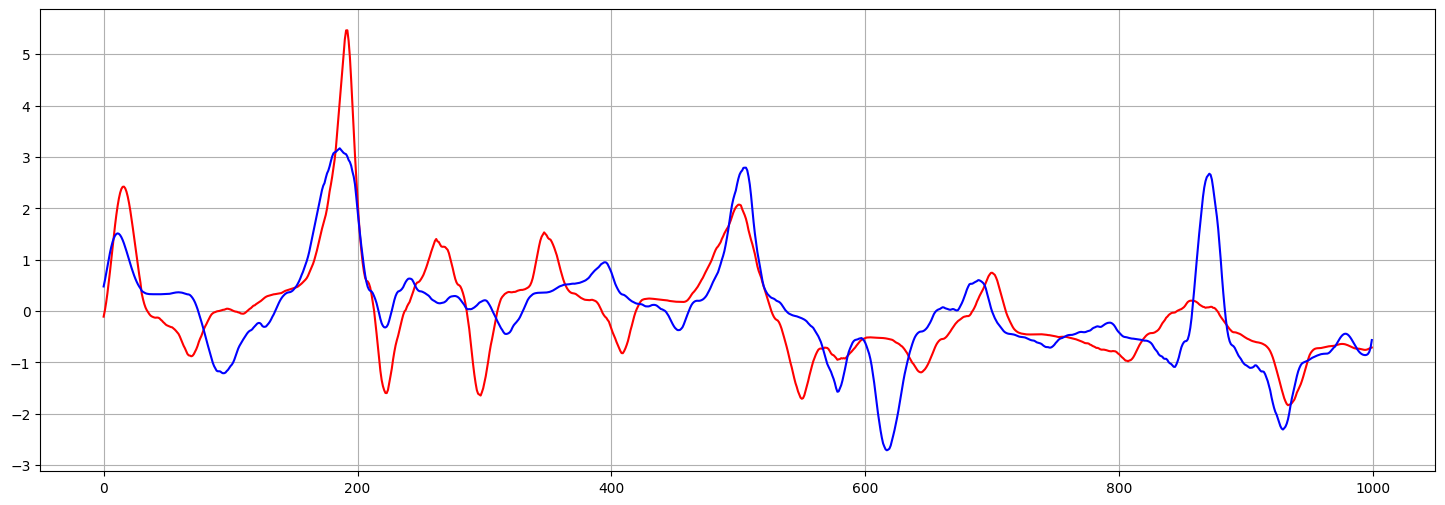

In [122]:
id = 337198
window = 1220
sample = dataset_df['VALUE'][id:id+window].tolist()
sample = resample_normalize(sample, 1000)

figure = plt.figure(figsize=(18, 6))
plt.plot(normalize(origin_signal), label='Original', color='gray')
plt.plot(normalize(sample), label='Sample', color='blue')
plt.grid(True)

rhyme_sample = rhyme_func(sample)
rhyme_signal = rhyme_func(origin_signal)

print(np.linalg.norm(rhyme_sample))
print(np.linalg.norm(rhyme_signal))

plt.figure(figsize=(18, 6))
plt.plot(normalize(rhyme_signal), label='Rhyme', color='red')
plt.plot(normalize(rhyme_sample), label='Sample', color='blue')
plt.grid(True)


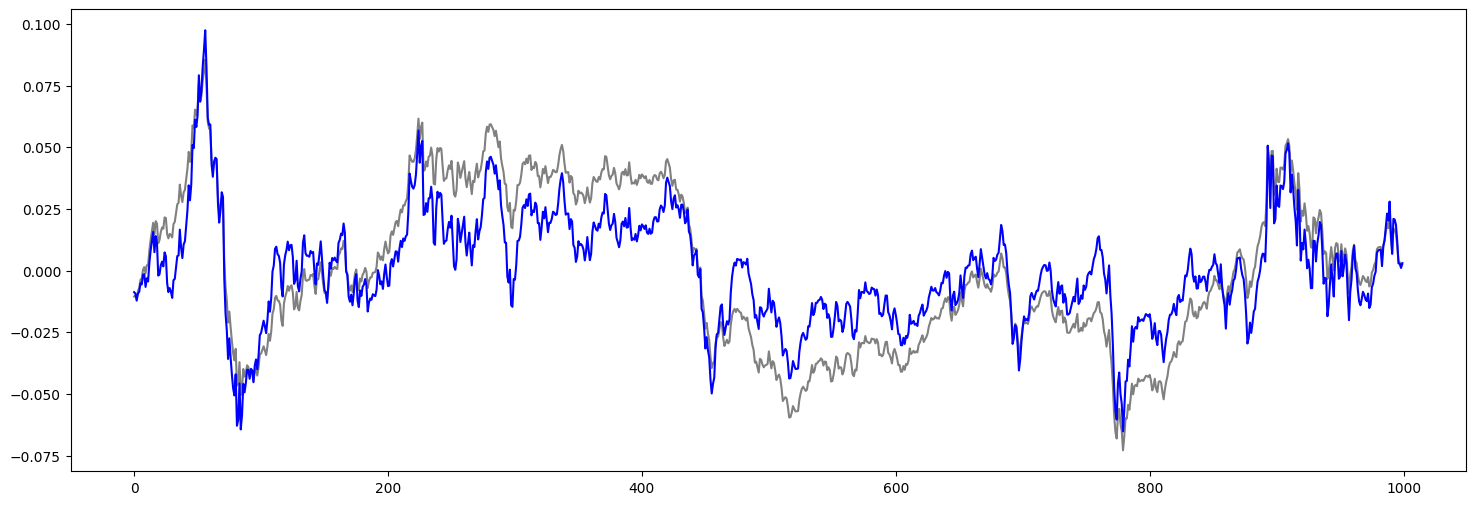

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(origin_signal, label='Original', color='gray')
plt.plot(hp_origin_signal + origin_signal * 0.5, color='blue')